# Import modules

In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
# from tqdm import tqdm
# import concurrent.futures

import sys
sys.path.append('../')

from src.config import *
from src.helper_visualization import *
# from src.helper_text import *
# from src.helper_langID import *
# from src.helper_translation import *
from src.helper_pred import *

# Prepare Data

## Load Cleaned Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157178 entries, 0 to 157177
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        157178 non-null  int64 
 1   Title             157178 non-null  object
 2   Product Name      157178 non-null  object
 3   Length            157178 non-null  int64 
 4   Language          157178 non-null  object
 5   Title_Processed   157178 non-null  object
 6   Title_Translated  157178 non-null  object
 7   Title_Cleaned     157178 non-null  object
dtypes: int64(2), object(6)
memory usage: 9.6+ MB
None


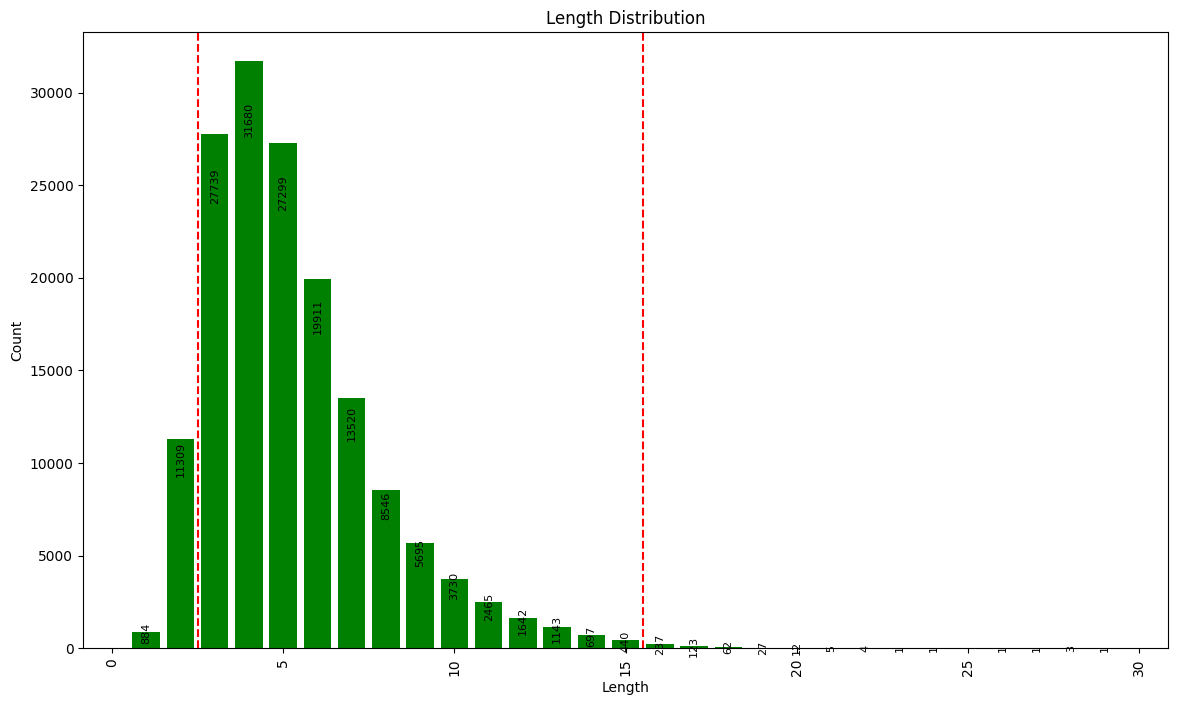

In [2]:
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_cleaned.xlsx'
df_cleaned = pd.read_excel(excel_file)
print(df_cleaned.info())
hist_by_labels(df_cleaned, 'Length', log=False, left=2.5, right=15.5)
# plot a square in red color on the histogram

## Remove short Titles

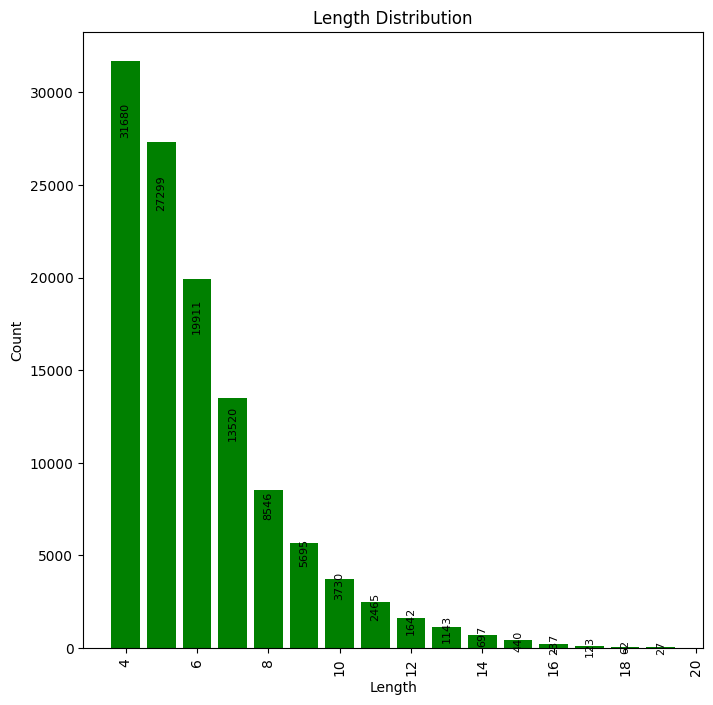

In [3]:
# filter out the titles with length less than 3 and more than 20
# when the title is too short, it is either not useful or it is too obvious to be classified
mask = (df_cleaned['Length'] > 3) & (df_cleaned['Length'] < 20)
df_cleaned = df_cleaned[mask]
hist_by_labels(df_cleaned, 'Length', horizontal=True)

## Combine the long tail into Others

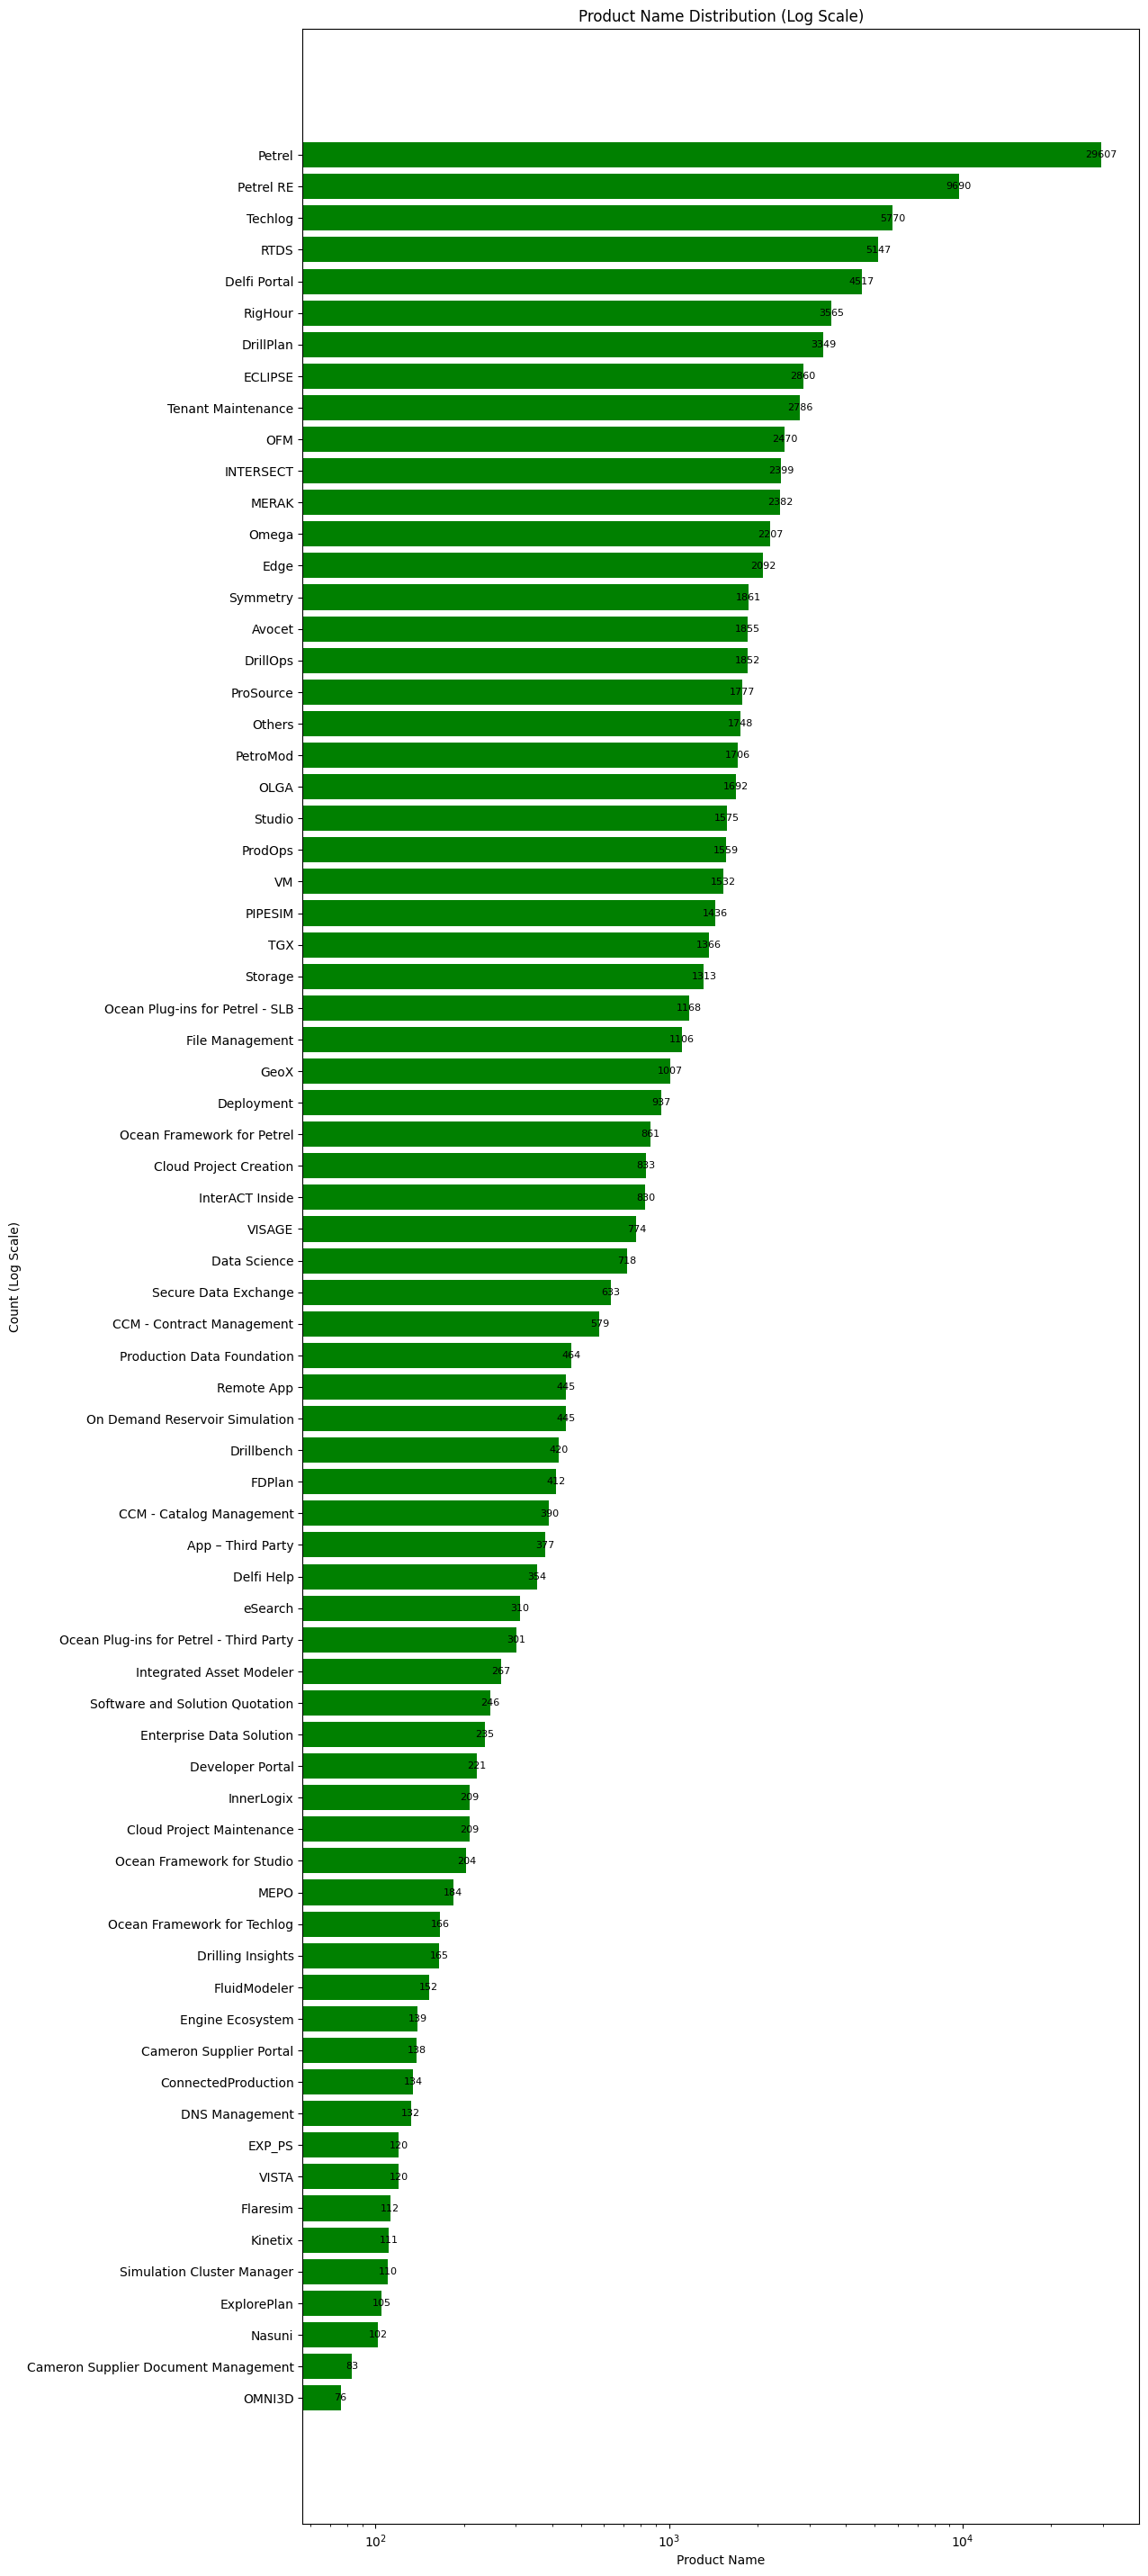

In [4]:
hist_by_labels(df_cleaned, 'Product Name', top=None, log=True, horizontal=False)

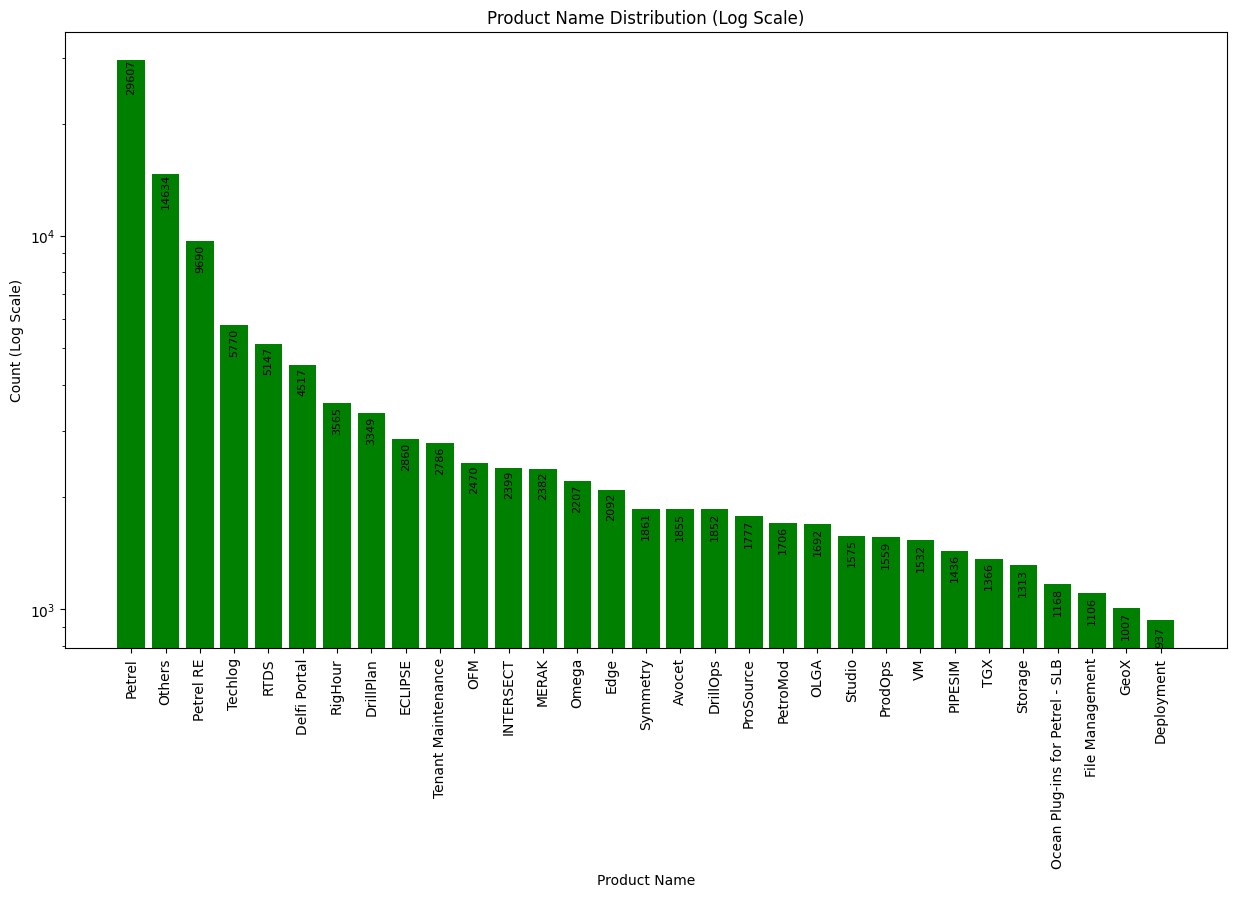

In [5]:
# Keep the top 50 products and combine the rest into 'Others'
product_counts = df_cleaned['Product Name'].value_counts()
cutoff = 900
product_top = product_counts.index[product_counts >= cutoff]
product_others = product_counts.index[product_counts < cutoff]

mask_others = df_cleaned['Product Name'].isin(product_others)
df_cleaned.loc[mask_others,'Product Name']='Others'
hist_by_labels(df_cleaned, 'Product Name', log=True)

## Train/Test Split

<class 'pandas.core.frame.DataFrame'>
Index: 61899 entries, 69721 to 76452
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        61899 non-null  int64 
 1   Title             61899 non-null  object
 2   Product Name      61899 non-null  object
 3   Length            61899 non-null  int64 
 4   Language          61899 non-null  object
 5   Title_Processed   61899 non-null  object
 6   Title_Translated  61899 non-null  object
 7   Title_Cleaned     61899 non-null  object
dtypes: int64(2), object(6)
memory usage: 4.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 55318 entries, 2 to 137771
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        55318 non-null  int64 
 1   Title             55318 non-null  object
 2   Product Name      55318 non-null  object
 3   Length            55318 non-null  int64

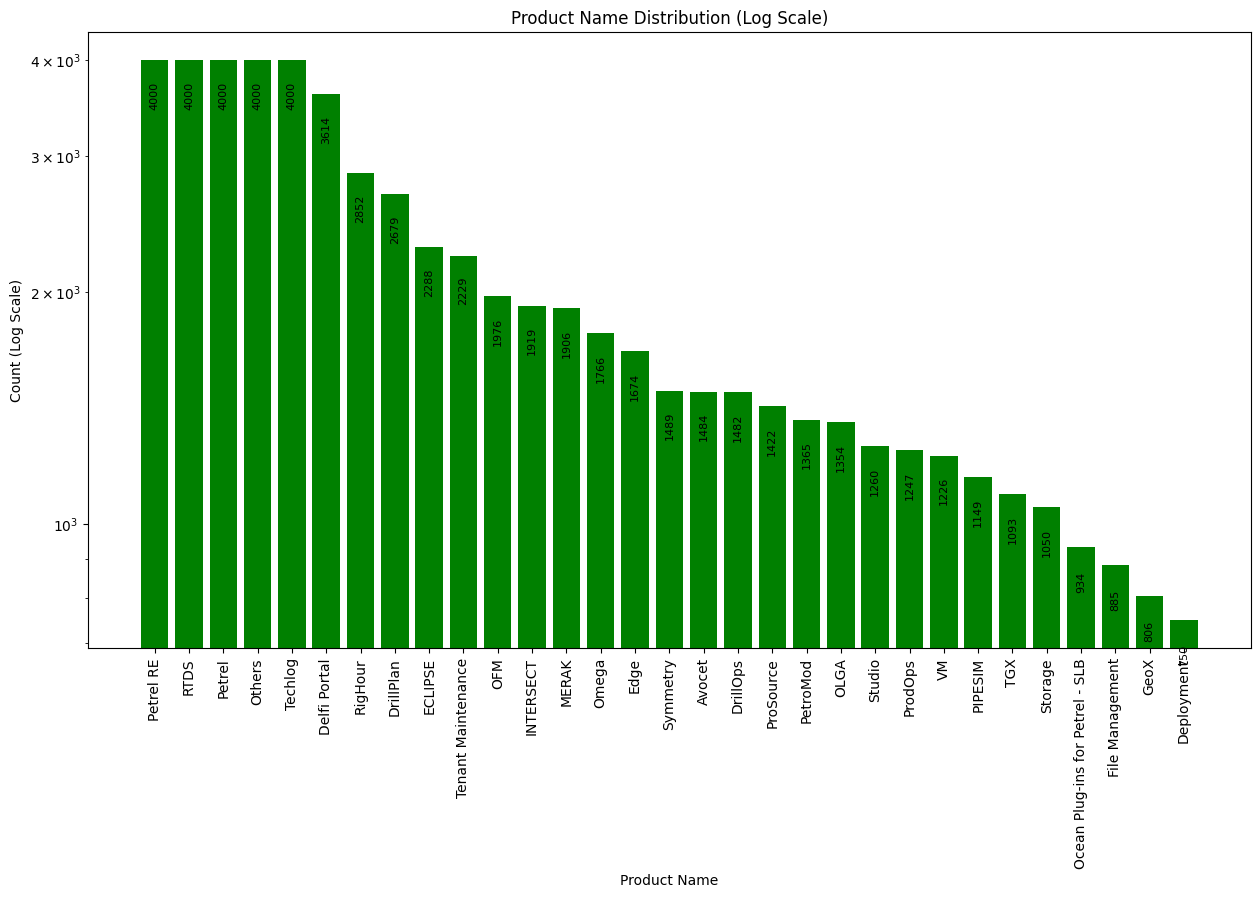

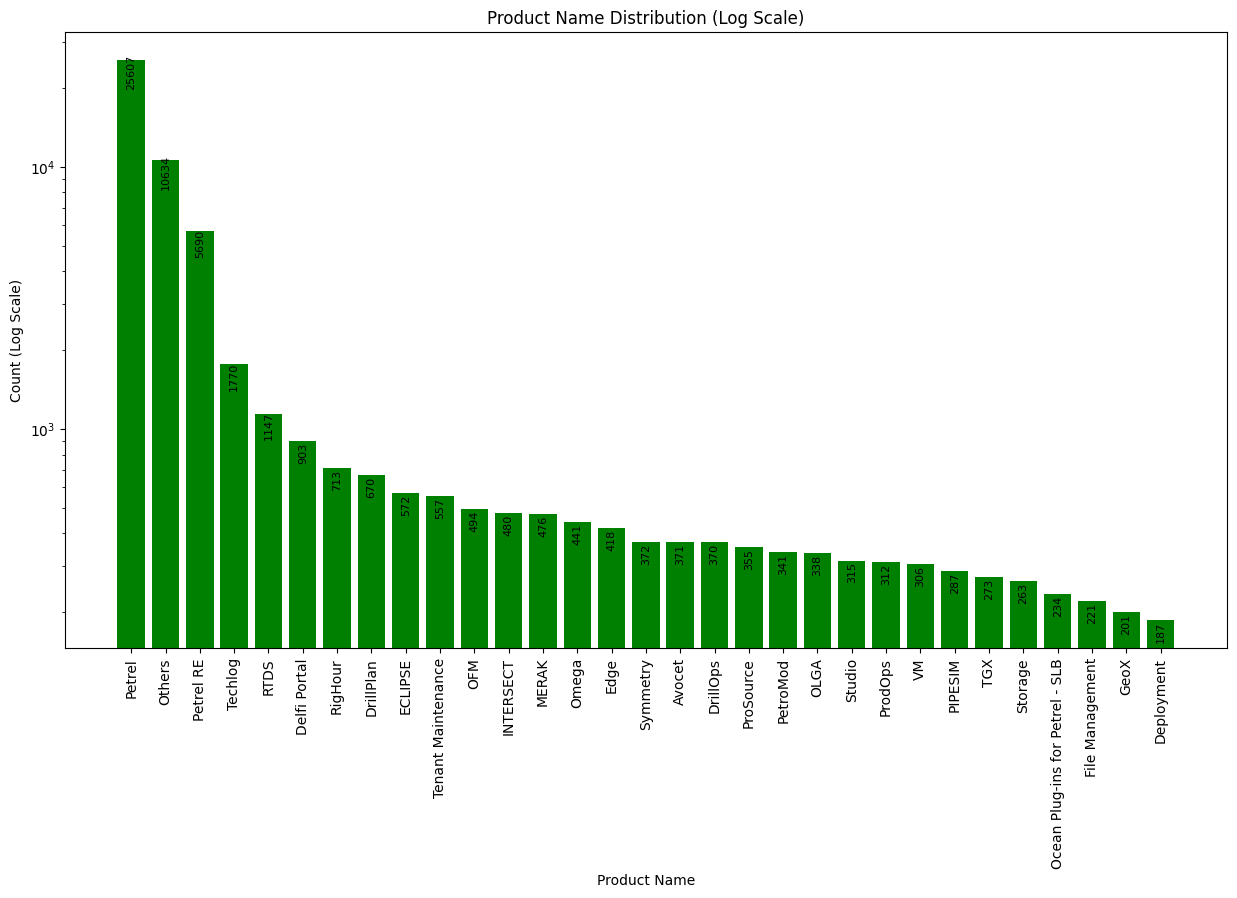

In [6]:
# for the products with more than 5000 records, randomly select 4000 records for each product and put in a new dataframe df_cleaned_balanced, then keep the rest of the records in df_cleaned_test
df_cleaned_balanced = pd.DataFrame()
df_cleaned_test = pd.DataFrame()
for product in df_cleaned['Product Name'].unique():
    df_product = df_cleaned[df_cleaned['Product Name'] == product]
    if df_product.shape[0] > 5000:
        df_product_balanced = df_product.sample(4000).copy()
        df_cleaned_balanced = pd.concat([df_cleaned_balanced, df_product_balanced])
        df_product_test = df_product.drop(df_product_balanced.index)
        df_cleaned_test = pd.concat([df_cleaned_test, df_product_test])
    else:
        df_product_balanced = df_product.sample(frac=0.8).copy()
        df_cleaned_balanced = pd.concat([df_cleaned_balanced, df_product_balanced])
        df_product_test = df_product.drop(df_product_balanced.index)
        df_cleaned_test = pd.concat([df_cleaned_test, df_product_test])

print(df_cleaned_balanced.info())
print(df_cleaned_test.info())

hist_by_labels(df_cleaned_balanced, 'Product Name', log=True)
hist_by_labels(df_cleaned_test, 'Product Name', log=True)

In [9]:
# Prepare data for training and testing for 
# a. cross validation
# b. logistic regression, 
# c. SGC Classifier

#import packages related to data
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

X = df_cleaned['Title_Cleaned']
vectorizer = CountVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2))
vectorizer.fit(X)

X_train = df_cleaned_balanced['Title_Cleaned']
X_train_encoded = vectorizer.transform(X_train)
y_train = df_cleaned_balanced['Product Name']

X_test = df_cleaned_test['Title_Cleaned']
X_test_encoded = vectorizer.transform(X_test)
y_test = df_cleaned_test['Product Name']

# Train Models

## Model Baseline - Cross Validation

In [7]:
# Model Tuning
from sklearn.model_selection import cross_validate

# Models
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
# import xgboost as xgb

import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [10]:
models = {
    'MultinomialNB': MultinomialNB(),
    'SGDClassifier': SGDClassifier(max_iter=5000),
    'LogisticRegression': LogisticRegression(max_iter=5000),
    # 'SVC rbf': SVC(kernel='rbf'),
    # 'SVC linear': SVC(kernel='linear'),
    # 'RandomForestClassifier': RandomForestClassifier(),
    # 'GradientBoostingClassifier': GradientBoostingClassifier(),
    # 'XGBClassifier': xgb.XGBClassifier()
}

print('Baseline Score(s) of each model are ....')

for model in models:
    cv_result = cross_val_score(
        models[model], 
        X_train_encoded, # please provide the features after preprocessing
        y_train, #the target
        cv=5, 
        scoring='accuracy', # lease revise to the appropriate score
        n_jobs=-1
    )
    print(f'Average score: \033[94m{"{:.4f}".format(np.mean(cv_result))}\033[0m by \033[94m{model}\033[0m.')

Baseline Score(s) of each model are ....
Average score: 0.7470 by MultinomialNB.
Average score: 0.7856 by SGDClassifier.
Average score: 0.7885 by LogisticRegression.


## Hpyerparameter Tuning

## SGC Classifier

In [11]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'alpha': trial.suggest_float('alpha', 1e-6, 1e+2, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'max_iter': 5000,
        'random_state': 42
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=200, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
# Create and train the best Logistic Regression model
best_model_sgc = SGDClassifier(**best_params)
best_model_sgc.fit(X_train_encoded, y_train)
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2023-10-20 10:01:17,519] A new study created in memory with name: no-name-f2d95a6a-d167-4bdd-8d56-0ca24f9927bb


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2023-10-20 10:01:24,593] Trial 7 finished with value: 0.0646213994438703 and parameters: {'loss': 'modified_huber', 'alpha': 52.1736136554786, 'penalty': 'l1'}. Best is trial 7 with value: 0.0646213994438703.
[I 2023-10-20 10:01:24,911] Trial 0 finished with value: 0.7328389981417536 and parameters: {'loss': 'log_loss', 'alpha': 0.00026689375322593245, 'penalty': 'l2'}. Best is trial 0 with value: 0.7328389981417536.
[I 2023-10-20 10:01:26,130] Trial 6 finished with value: 0.0646213994438703 and parameters: {'loss': 'log_loss', 'alpha': 3.7078226084956367, 'penalty': 'l1'}. Best is trial 0 with value: 0.7328389981417536.
[I 2023-10-20 10:01:26,221] Trial 4 finished with value: 0.0646213994438703 and parameters: {'loss': 'log_loss', 'alpha': 4.7405078816521655, 'penalty': 'l1'}. Best is trial 0 with value: 0.7328389981417536.
[I 2023-10-20 10:01:33,040] Trial 11 finished with value: 0.48509685940844377 and parameters: {'loss': 'modified_huber', 'alpha': 0.008931602364485572, 'penalty

                                 precision    recall  f1-score   support

                         Avocet      0.548     0.779     0.644       371
                   Delfi Portal      0.220     0.611     0.323       903
                     Deployment      0.516     0.599     0.554       187
                       DrillOps      0.821     0.919     0.867       370
                      DrillPlan      0.557     0.901     0.689       670
                        ECLIPSE      0.264     0.607     0.368       572
                           Edge      0.974     0.988     0.981       418
                File Management      0.423     0.787     0.551       221
                           GeoX      0.676     0.881     0.765       201
                      INTERSECT      0.299     0.650     0.410       480
                          MERAK      0.799     0.935     0.862       476
                            OFM      0.796     0.870     0.832       494
                           OLGA      0.806     0.8

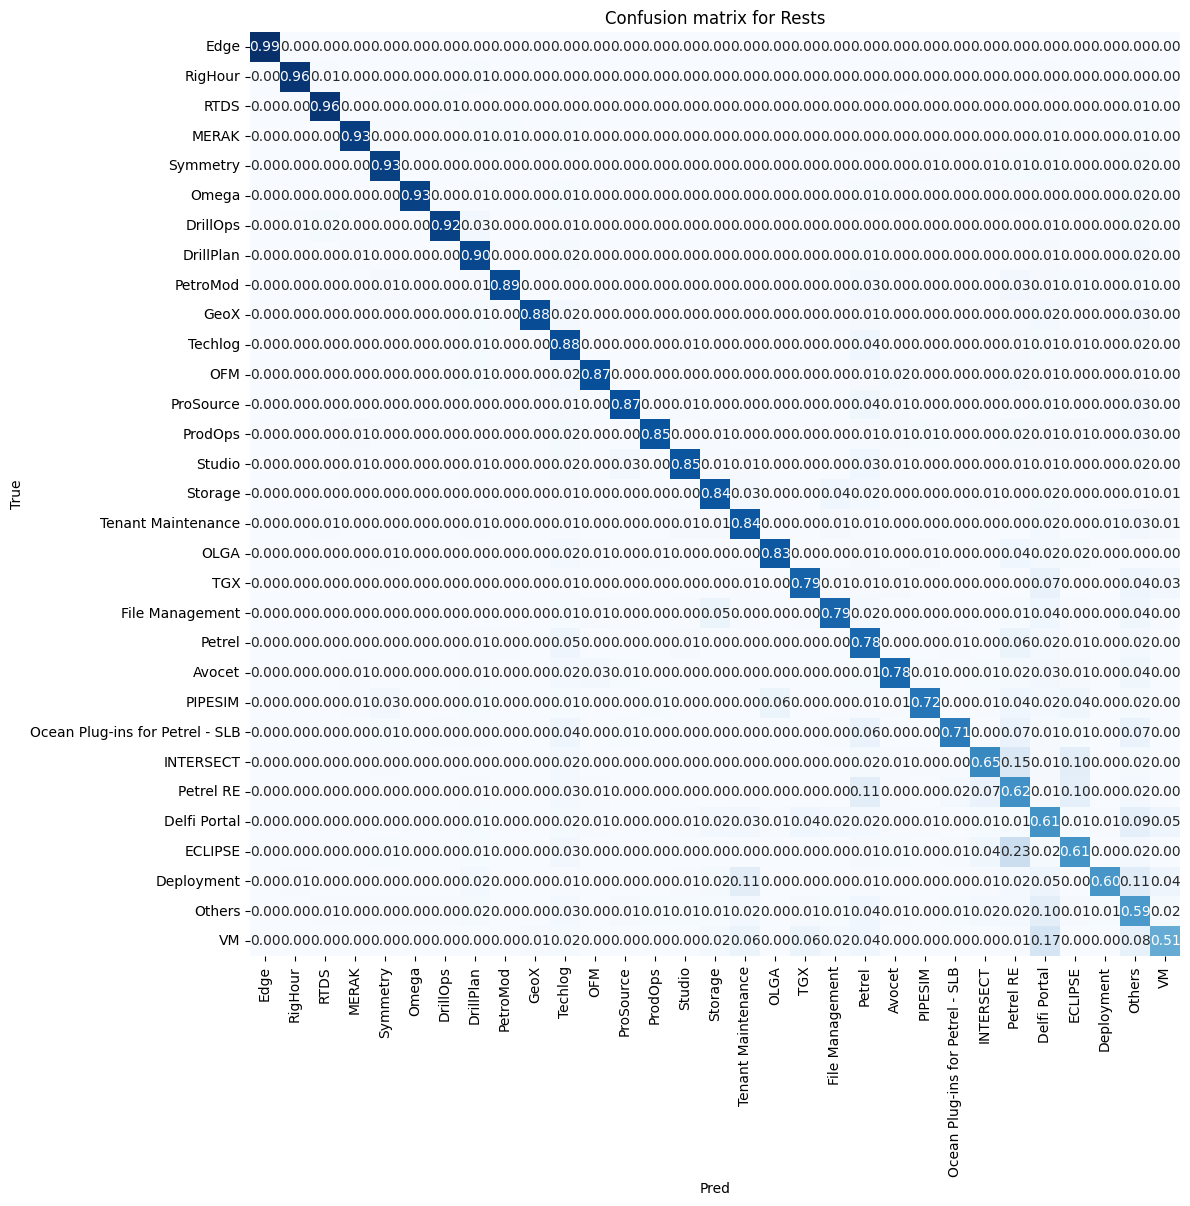

In [12]:
# Predict categories for the test data
y_pred_sgc = best_model_sgc.predict(X_test_encoded)
# Evaluate the classifier's performance
print(classification_report(y_test, y_pred_sgc, digits=3))
plot_confusion_matrix(y_test, y_pred_sgc, title='Confusion matrix for Rests')
df_pred_top5_sgc = top5_accuracy_report(best_model_sgc, vectorizer, X_test, y_test, pre_processed=True)

In [63]:
# export the model
import pickle
pickle.dump(best_model_sgc, open(f'{MODEL_FOLDER_PATH}/model_sgc_classifier.pkl', 'wb'))

# export the vectorizer
pickle.dump(vectorizer, open(f'{MODEL_FOLDER_PATH}/vectorizer_sgc_classifier.pkl', 'wb'))


## Logistic Classification

Accuracy: 0.737
                                 precision    recall  f1-score   support

                         Avocet      0.539     0.790     0.640       371
                   Delfi Portal      0.221     0.649     0.330       903
                     Deployment      0.508     0.701     0.589       187
                       DrillOps      0.788     0.914     0.846       370
                      DrillPlan      0.526     0.879     0.658       670
                        ECLIPSE      0.262     0.601     0.365       572
                           Edge      0.981     0.967     0.973       418
                File Management      0.482     0.778     0.595       221
                           GeoX      0.685     0.856     0.761       201
                      INTERSECT      0.303     0.648     0.413       480
                          MERAK      0.797     0.941     0.863       476
                            OFM      0.792     0.868     0.828       494
                           OLGA   

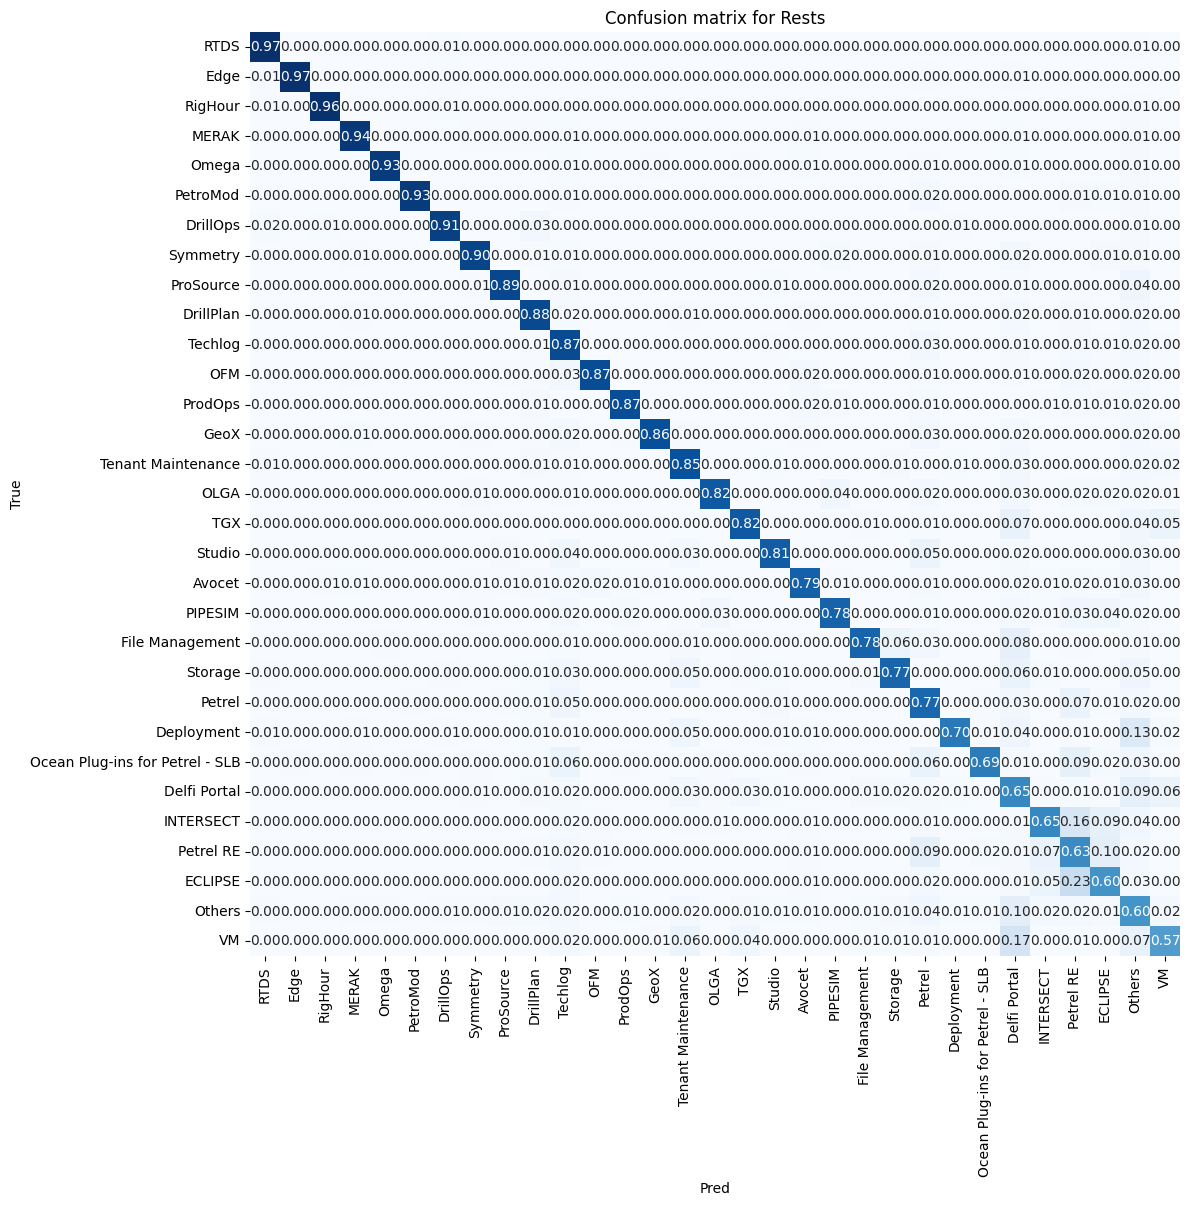

Accuracy of top 1 prediction is 0.737.
Accuracy of top 3 prediction is 0.927.
Accuracy of top 5 prediction is 0.965.


In [64]:
# weights = df_rests['ProductName'].value_counts().apply(np.sqrt).to_dict()
model_logReg = LogisticRegression(
    max_iter=5000,
    # class_weight= weights
)
model_logReg.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_logReg = model_logReg.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_logReg)
print(f"Accuracy: {accuracy:.3f}")

report = classification_report(y_test, y_pred_logReg, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_logReg, title='Confusion matrix for Rests')
df_pred_top5_logReg = top5_accuracy_report(model_logReg, vectorizer, X_test, y_test, pre_processed=True)

In [65]:
# export the model
import pickle
pickle.dump(model_logReg, open(f'{MODEL_FOLDER_PATH}/model_logistic_regression.pkl', 'wb'))

# export the vectorizer
pickle.dump(vectorizer, open(f'{MODEL_FOLDER_PATH}/vectorizer_logistic_regression.pkl', 'wb'))

## MultinomialNB

In [66]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space of MultinomialNB model
    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e+2, log=True),
        'fit_prior': trial.suggest_categorical('fit_prior', [True, False])
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_multinomialNB = MultinomialNB(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_multinomialNB, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=300, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

# Create and train the best Logistic Regression model
best_model_multinomialNB = MultinomialNB(**best_params)
best_model_multinomialNB.fit(X_train_encoded, y_train)
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2023-10-19 17:23:15,147] A new study created in memory with name: no-name-d6d61100-2d00-4b59-bb5a-68e086b134f9


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2023-10-19 17:23:19,013] Trial 0 finished with value: 0.7314496304844791 and parameters: {'alpha': 3.468322087922796e-06, 'fit_prior': False}. Best is trial 0 with value: 0.7314496304844791.
[I 2023-10-19 17:23:19,545] Trial 3 finished with value: 0.6848737471780144 and parameters: {'alpha': 5.3362421208029, 'fit_prior': True}. Best is trial 0 with value: 0.7314496304844791.
[I 2023-10-19 17:23:19,726] Trial 5 finished with value: 0.746748752805999 and parameters: {'alpha': 0.0013552570335984638, 'fit_prior': True}. Best is trial 5 with value: 0.746748752805999.
[I 2023-10-19 17:23:19,734] Trial 6 finished with value: 0.6418036016752013 and parameters: {'alpha': 46.33671292452509, 'fit_prior': False}. Best is trial 5 with value: 0.746748752805999.
[I 2023-10-19 17:23:19,744] Trial 2 finished with value: 0.7601415459319883 and parameters: {'alpha': 0.1142443847800606, 'fit_prior': True}. Best is trial 2 with value: 0.7601415459319883.
[I 2023-10-19 17:23:19,788] Trial 9 finished with

Accuracy: 0.689
                                 precision    recall  f1-score   support

                         Avocet      0.498     0.803     0.615       371
                   Delfi Portal      0.204     0.605     0.305       903
                     Deployment      0.288     0.684     0.406       187
                       DrillOps      0.623     0.916     0.742       370
                      DrillPlan      0.480     0.887     0.623       670
                        ECLIPSE      0.233     0.551     0.327       572
                           Edge      0.890     0.971     0.929       418
                File Management      0.280     0.792     0.414       221
                           GeoX      0.583     0.801     0.675       201
                      INTERSECT      0.243     0.621     0.350       480
                          MERAK      0.710     0.941     0.809       476
                            OFM      0.575     0.834     0.680       494
                           OLGA   

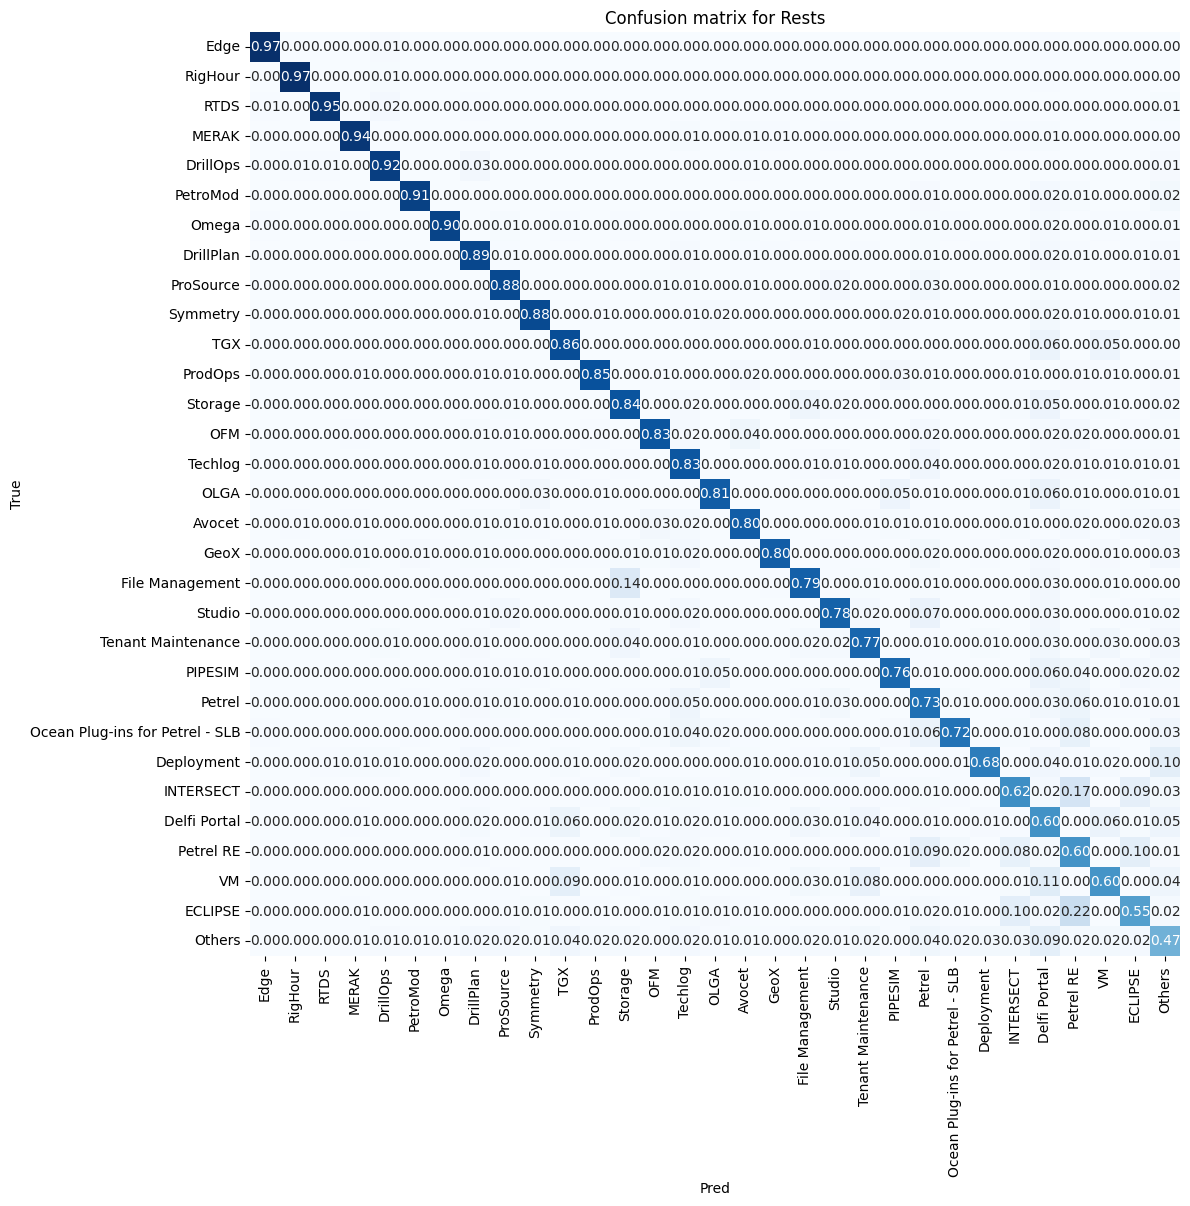

Accuracy of top 1 prediction is 0.689.
Accuracy of top 3 prediction is 0.889.
Accuracy of top 5 prediction is 0.943.


In [67]:
# weights = df_rests['ProductName'].value_counts().apply(np.sqrt).to_dict()
model_multinomialNB = best_model_multinomialNB

# Step 4: Model Evaluation
y_pred_multinomialNB = model_multinomialNB.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_multinomialNB)
print(f"Accuracy: {accuracy:.3f}")

report = classification_report(y_test, y_pred_multinomialNB, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_multinomialNB, title='Confusion matrix for Rests')
df_pred_top5_multinomialNB = top5_accuracy_report(model_multinomialNB, vectorizer, X_test, y_test, pre_processed=True)

In [68]:
pickle.dump(best_model_multinomialNB, open(f'{MODEL_FOLDER_PATH}/model_multinomialNB.pkl', 'wb'))

# export the vectorizer
pickle.dump(vectorizer, open(f'{MODEL_FOLDER_PATH}/vectorizer_multinomialNB.pkl', 'wb'))